# **Mask-RCNN for instance segmentation**

**1. Semantic Segmentation:** In semantic segmentation, we assign a class label (e.g. dog, cat, person, background, etc.) to every pixel in the image.

**2. Object Detection:** In object detection, we assign a class label to bounding boxes that contain objects.

**3. Instance Segmentation:** A very natural idea is to combine the above two together. We want to only identify a bounding box around an object and we want to find which of the pixels inside the bounding box belong to the object.

Instance segmentation and semantic segmentation differ in two ways

In semantic segmentation, every pixel is assigned a class label, while in instance segmentation that is not the case.
We do not tell the instances of the same class apart in semantic segmentation. For example, all pixels belonging to the “person” class in semantic segmentation will be assigned the same color/value in the mask. In instance segmentation, they are assigned different values and we are able to tell them which pixels correspond to which person. We can see this in the above image.

### **1. Mask R-CNN Architecture**

The architecture of Mask R-CNN is an extension of Faster R-CNN.

The Faster R-CNN architecture had the following components:

**1. Convolutional Layers:** The input image is passed through several convolutional layers to create a feature map. If you are a beginner, think of the convolutional layers as a black box that takes in a 3-channel input image, and outputs an “image” with a much smaller spatial dimension (7×7), but a large number of channels (512).

**2. Region Proposal Network (RPN):** The output of the convolutional layers is used to train a network that proposes regions that enclose objects.

**3. Classifier:** The same feature map is also used to train a classifier that assigns a label to the object inside the box.

Also, recall that Faster R-CNN was faster than Fast R-CNN because the feature map was computed once and reused by the RPN and the classifier.

Mask R-CNN takes the idea one step further. In addition to feeding the feature map to the RPN and the classifier, it uses it to predict a binary mask for the object inside the bounding box.

One way of looking at the mask prediction part of Mask R-CNN is that it is a Fully Convolutional Network (FCN) used for semantic segmentation. The only difference is that the FCN is applied to bounding boxes, and it shares the convolutional layer with the RPN and the classifier.

The figure below shows a very high level architecture.

<img src="https://s3.ap-south-1.amazonaws.com/techleerimages/27161df8-36b0-445a-a106-23f76090e0d4.png"/>

### **2. Input and Output**
The model expects the input to be a list of tensor images of shape (n, c , h, w), with values in the range 0-1. The size of images need not be fixed.

*n is the number of images*

*c is the number of channels, for RGB images it is 3*

*h is the height of the image*

*w is the width of the image*


The model returns
coordinates of bounding boxes,
labels of classes the model predicts to be present in the input image, scores of the labels,
the masks for each class present in the labels.

## Implementation

In [29]:
import torch
import torchvision
import torchvision.transforms as T
import cv2
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
# load the model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

In [21]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [22]:
def get_prediction(img_path, threshold):
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class

In [23]:
def random_colour_masks(image):
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask

In [34]:
def instance_segmentation_api(img_path, threshold=0.5, rect_th=3, text_size=1, text_th=3):
    masks, boxes, pred_cls = get_prediction(img_path, threshold)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
        rgb_mask = random_colour_masks(masks[i])
        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

<ipython-input-34-e08f5091bca0>:8: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
<ipython-input-34-e08f5091bca0>:9: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)


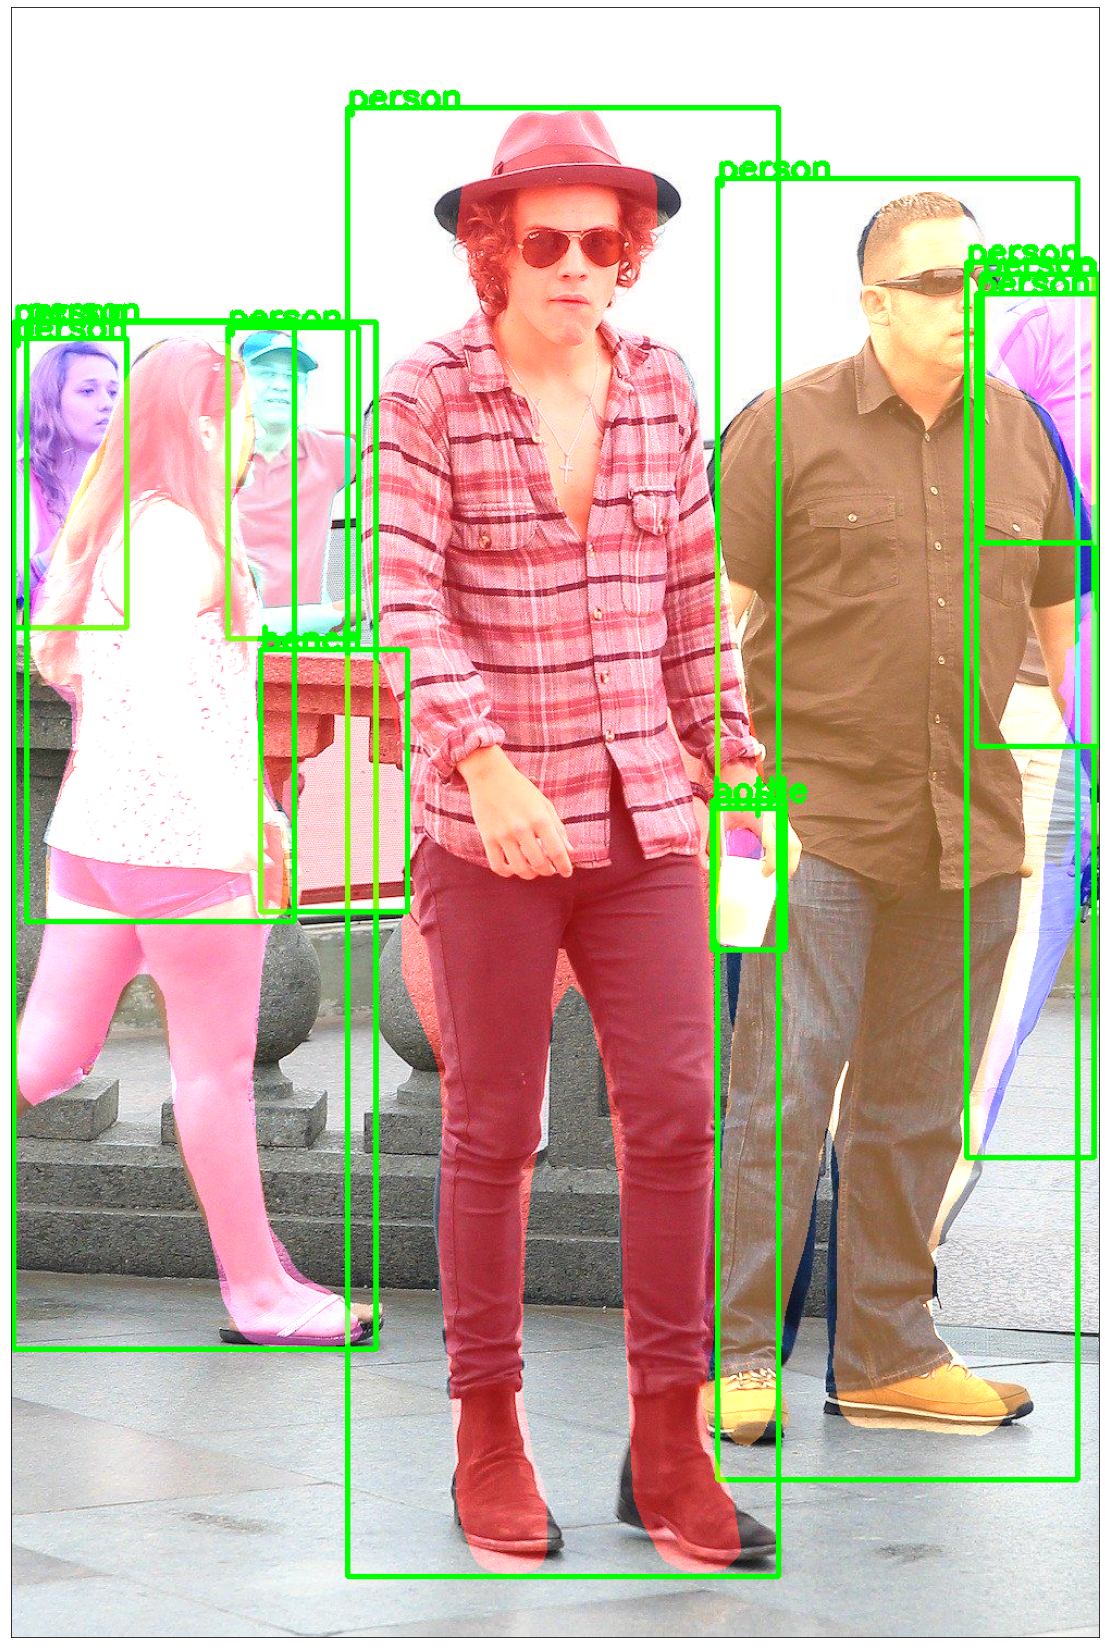

In [35]:
plt.rcParams["figure.figsize"] = (10,10)
instance_segmentation_api('tests/cleavage.jpeg')

In [37]:
img_path = 'tests/cleavage.jpeg'
threshold = 0.5
masks, boxes, pred_cls = get_prediction(img_path, threshold)

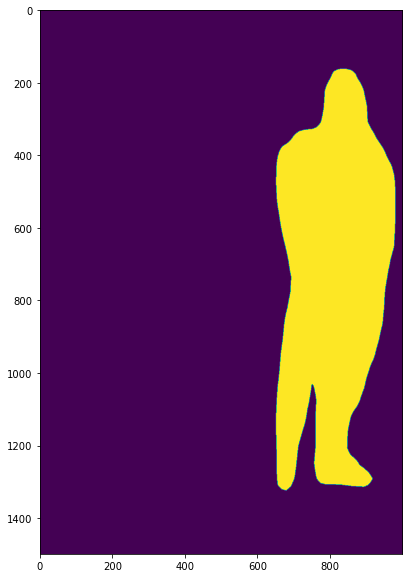

In [43]:
plt.imshow(masks[0])

In [47]:
torch.tensor([1,2]).unsqueeze(0)

tensor([[1, 2]])